## Introduction  
In this lab, we would like to make an XGBoost model to study the e-commerce behavior from a multi-category store. First, we need to download the data to your local machine, then we will load the data into a Pandas DataFrame.

## Objectives
- Apply XGBoost to an example

## Instruction
* Accept the Kaggle policy and download the data from [Kaggle](https://www.kaggle.com/code/tshephisho/ecommerce-behaviour-using-xgboost/data)
* For the first model you will only use the 2019-Nov csv data (which is still around ~2gb zipped)

In [55]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime

In [56]:
# fill this in with your path (absolute path works as well)
path_to_file = "2019-Nov.csv"
df = pd.read_csv(path_to_file)

Start with some exploratory analysis. First, take a look at the first five rows of the DataFrame. Then get the information about the DataFrame, what is the shape of the DataFrame, and what are the coumn names?

In [57]:
# your code
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [58]:
# your code
df.shape

(67501979, 9)

In [59]:
# your code
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501979 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.5+ GB


In [60]:
# your code

# Know your Customers
How many unique customers visit the site? Assign the number of visitors to the visitor variable and print it out

In [61]:
# your code
df["user_id"].nunique()

3696117

# Visitors Daily Trend
Does traffic fluctuate by date? Try using the `event_time` and `user_id` to see traffic. First you need to select by `event_time` and `user_id`, then you will `drop_duplicates` and `groupby` `event_time` and `user_id`.

In [62]:
d = df.loc[:, ["event_time", "user_id"]]
d["event_time"] = d["event_time"].apply(lambda s: str(s)[0:10])
visitor_by_date = (
    d.drop_duplicates()
    .groupby(["event_time"])["user_id"]
    .agg(["count"])
    .sort_values(by=["event_time"], ascending=True)
)
x = pd.Series(visitor_by_date.index.values).apply(
    lambda s: datetime.strptime(s, "%Y-%m-%d").date()
)
y = visitor_by_date["count"]

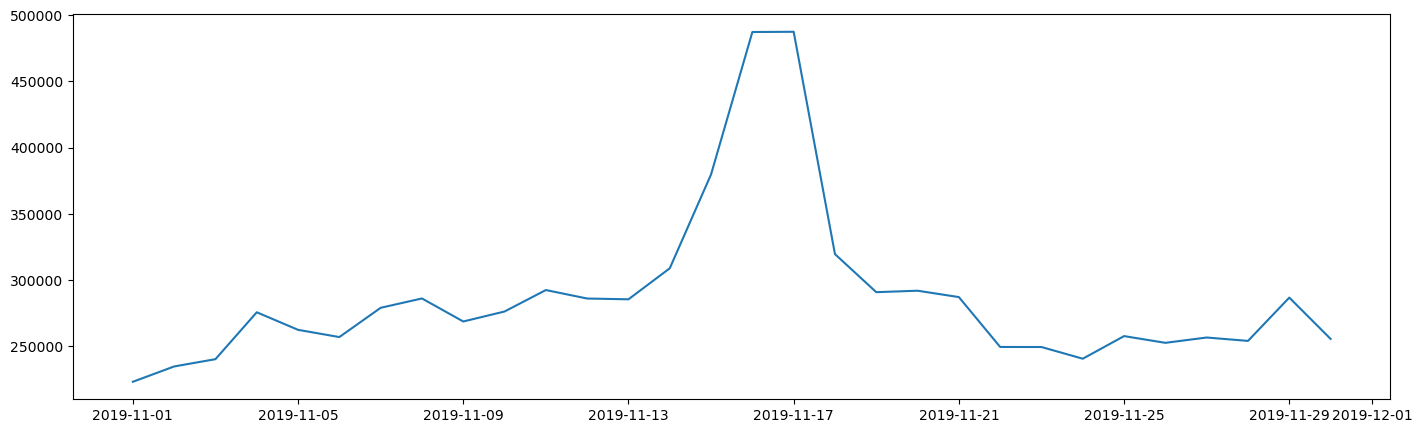

In [63]:
plt.rcParams["figure.figsize"] = (17, 5)
plt.plot(x, y)
plt.show()

### By Category and Product
Which category do customers interact with the most? What brand do they view the most? You can choose just the categories with at least 30 records in order to construct the plots.

In [64]:
max_category_num = 30
top_category = (
    df.loc[:, "category_code"]
    .value_counts()[:max_category_num]
    .sort_values(ascending=False)
)

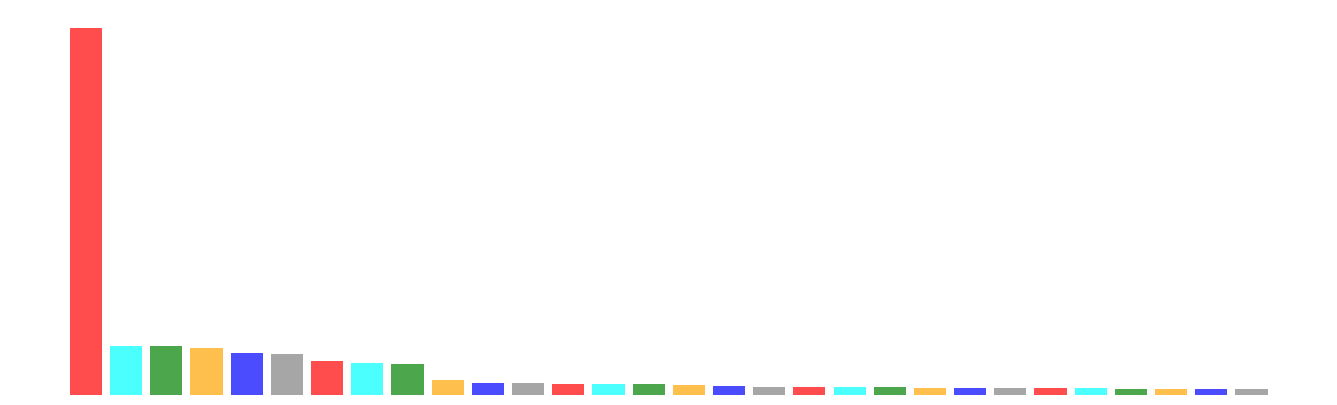

In [65]:
plt.bar(
    height=top_category,
    x=top_category.index.array,
    color=["red", "cyan", "green", "orange", "blue", "grey"],
    alpha=0.7,
)
plt.axis("off")
plt.show()

## Purchases

When the event_type is "purchase", what item do customers buy?

Try using `'event_type' == 'purchase'` and drop empty rows to assess which categories customers buy.

In [66]:
# your code
df.query("event_type == 'purchase'")["category_code"].value_counts()

category_code
electronics.smartphone           382647
electronics.audio.headphone       40834
electronics.video.tv              30274
electronics.clocks                23237
appliances.kitchen.washer         19772
                                  ...  
construction.tools.soldering          6
country_yard.furniture.hammok         4
apparel.shorts                        2
construction.tools.screw              1
appliances.kitchen.fryer              1
Name: count, Length: 126, dtype: int64

## What brands do the customers buy?
Try grouping by brand and sorting the values by the brand name.

In [67]:
# your code
df.query("event_type == 'purchase'")["brand"].value_counts().sort_index()

brand
a-case               94
a-elita               1
a-mega               12
aardwolf              7
absolutechampion      1
                   ... 
zotac                 7
zte                 112
zubr                179
zuru                  3
zvezda                1
Name: count, Length: 2486, dtype: int64

In [68]:
del d  # free memory

# Modeling: predict at the time of addition to a shopping cart if the user will purchase a given product or not

### Feature engineering

The goal of this modeling is to predict if the user will purchase a product or not when they add the product to the cart. This is called `cart abandonment` if the user does not purchase.

First, reconstruct and restructure the data to feed into the machine learning model. For this use case, target only the data for which customers have "put" the product into the cart. The relevant `event_type`s are thus "cart" and "purchase".

Create these new features in the training data set:
- `activity_count`: number of activity in that session
- `category_level1`: category
- `category_level2`: sub-category --> split on the "." in the category name
- `weekday`: weekday of the event --> convert `event_time` to a datetime object, then use `pandas.Timestamp.weekday`
- `is_purchased`: whether the is purchased after being put in the cart, this will be the categorical output.

Make sure to de-dup any record.

**Prepare a dataframe for counting activity in the session**

In [69]:
# your code
# first just eliminate the records where event_type = "view" and drop NA values and duplicates
cart_purchase_users_all_activity = df.query(
    "event_type != 'view'"
).dropna().drop_duplicates()

In [70]:
# now you get the number of activities by user session

activity_in_session = (
    cart_purchase_users_all_activity.groupby(["user_session"])["event_type"]
    .count()
    .reset_index()
)
activity_in_session = activity_in_session.rename(
    columns={"event_type": "activity_count"}
)
df_targets = cart_purchase_users_all_activity.copy()

In [71]:
# create the two new columns for the category levels 1 and 2
# your code here
df_targets["category_level1"] = df_targets["category_code"].apply(
    lambda s: s.split(".")[0] if isinstance(s, str) else s
)

In [72]:
df_targets["category_level1"].iloc[:5]

40     electronics
168    electronics
502    electronics
537    electronics
707    electronics
Name: category_level1, dtype: object

In [73]:
df_targets["category_level2"] = df_targets["category_code"].apply(
    lambda s: s.split(".")[1] if isinstance(s, str) else s
)
df_targets["category_level2"].iloc[:5]

40     smartphone
168    smartphone
502         video
537    smartphone
707    smartphone
Name: category_level2, dtype: object

In [74]:
# Change the event_time to a timestamp
# your code
df_targets["event_time"] = pd.to_datetime(df_targets["event_time"])
df_targets["event_time"].dtype

datetime64[ns, UTC]

In [75]:
# Use pandas.dt.dayofweek to get the day of the week
# your code
df_targets["weekday"] = df_targets["event_time"].apply(lambda s: s.dayofweek)

In [76]:
# add the is_purchased feature
# your code
df_targets["is_purchased"] = df["event_type"].apply(lambda s: 1 if s == "purchase" else 0)

In [77]:
df_targets = df_targets.merge(activity_in_session, on="user_session", how="left")
df_targets["activity_count"] = df_targets["activity_count"].fillna(0)
df_targets["brand"] = df_targets["brand"].astype("category")
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_level1,category_level2,weekday,is_purchased,activity_count
0,2019-11-01 00:00:14+00:00,cart,1005014,2053013555631882655,electronics.smartphone,samsung,503.09,533326659,6b928be2-2bce-4640-8296-0efdf2fda22a,electronics,smartphone,4,0,1
1,2019-11-01 00:01:04+00:00,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.92,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d,electronics,smartphone,4,1,1
2,2019-11-01 00:03:24+00:00,cart,1801881,2053013554415534427,electronics.video.tv,samsung,488.80,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e,electronics,video,4,0,14
3,2019-11-01 00:03:39+00:00,cart,1005115,2053013555631882655,electronics.smartphone,apple,949.47,565865924,fd4bd6d4-bd14-4fdc-9aff-bd41a594f82e,electronics,smartphone,4,0,1
4,2019-11-01 00:04:51+00:00,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,128.42,562958505,0f039697-fedc-40fa-8830-39c1a024351d,electronics,smartphone,4,1,1


### Save new data structure if desired

In [78]:
# df_targets.to_csv('training_data.csv')

In [79]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2704549 entries, 0 to 2704548
Data columns (total 14 columns):
 #   Column           Dtype              
---  ------           -----              
 0   event_time       datetime64[ns, UTC]
 1   event_type       object             
 2   product_id       int64              
 3   category_id      int64              
 4   category_code    object             
 5   brand            category           
 6   price            float64            
 7   user_id          int64              
 8   user_session     object             
 9   category_level1  object             
 10  category_level2  object             
 11  weekday          int64              
 12  is_purchased     int64              
 13  activity_count   int64              
dtypes: category(1), datetime64[ns, UTC](1), float64(1), int64(6), object(5)
memory usage: 273.4+ MB


In [80]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics

## Resampling training set

In [81]:
is_purcahase_set = df_targets[df_targets["is_purchased"] == 1]
is_purcahase_set.shape[0]

659251

In [82]:
not_purcahase_set = df_targets[df_targets["is_purchased"] == 0]
not_purcahase_set.shape[0]

2045298

In [83]:
n_samples = 500000
is_purchase_downsampled = resample(
    is_purcahase_set, replace=False, n_samples=n_samples, random_state=27
)
not_purcahase_set_downsampled = resample(
    not_purcahase_set, replace=False, n_samples=n_samples, random_state=27
)

In [84]:
downsampled = pd.concat([is_purchase_downsampled, not_purcahase_set_downsampled])
downsampled["is_purchased"].value_counts()

is_purchased
1    500000
0    500000
Name: count, dtype: int64

In [85]:
# select the brand, price, weekday, category_level1, cateogry_level2, and activity_count features

features = downsampled[['brand', 'price', 'weekday', 'category_level1', 'category_level2', 'activity_count']]

## Encode categorical variables

In [86]:
features.loc[:, "brand"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "brand"].copy()
)
features.loc[:, "weekday"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "weekday"].copy()
)
features.loc[:, "category_level1"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "category_level1"].copy()
)
features.loc[:, "category_level2"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "category_level2"].copy()
)

is_purchased = LabelEncoder().fit_transform(downsampled["is_purchased"])
features.head()

C:\Users\anjacobs\AppData\Local\Temp\ipykernel_7688\499591652.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  73   84 1038 ...   73   73 1038]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  features.loc[:, "brand"] = LabelEncoder().fit_transform(


,brand,price,weekday,category_level1,category_level2,activity_count
2358531,73,1002.90,1,7,40,2
2457359,84,152.72,2,7,55,2
1458408,1038,540.53,6,7,55,5
39519,73,458.25,5,7,40,3
1549305,1175,123.53,6,2,18,3


In [87]:
print(list(features.columns))

['brand', 'price', 'weekday', 'category_level1', 'category_level2', 'activity_count']


## Split the data
Use a test size of 0.3 and a random state of 86 to split the data into test and train subsets

In [97]:
# Fixing the warning by using .loc
features['category_level1'] = features['category_level1'].astype('int')
features['category_level2'] = features['category_level2'].astype('int')

C:\Users\anjacobs\AppData\Local\Temp\ipykernel_7688\2927362207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['category_level1'] = features['category_level1'].astype('int')
C:\Users\anjacobs\AppData\Local\Temp\ipykernel_7688\2927362207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['category_level2'] = features['category_level2'].astype('int')


In [98]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 2358531 to 1641201
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   brand            1000000 non-null  int32  
 1   price            1000000 non-null  float64
 2   weekday          1000000 non-null  int64  
 3   category_level1  1000000 non-null  int32  
 4   category_level2  1000000 non-null  int32  
 5   activity_count   1000000 non-null  int64  
dtypes: float64(1), int32(3), int64(2)
memory usage: 42.0 MB


In [99]:
X_train, X_test, y_train, y_test = train_test_split(features, is_purchased, test_size=0.3, random_state=86)

## Train the model
Choose learning rate of 0.1 on XGBClassifier, fit the model, and make predictions on the test set

In [100]:
from xgboost import XGBClassifier

model = XGBClassifier(learning_rate=0.1).fit(X_train, y_train)
# fit the model on the train sets
y_pred = model.predict(X_test)

In [101]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("fbeta:", metrics.fbeta_score(y_test, y_pred, average="weighted", beta=0.5))

Accuracy: 0.63731
Precision: 0.6207696226846022
Recall: 0.7064351024978007
fbeta: 0.6374479451892195


## Feature importance
Plot the feature importance using plot_importance

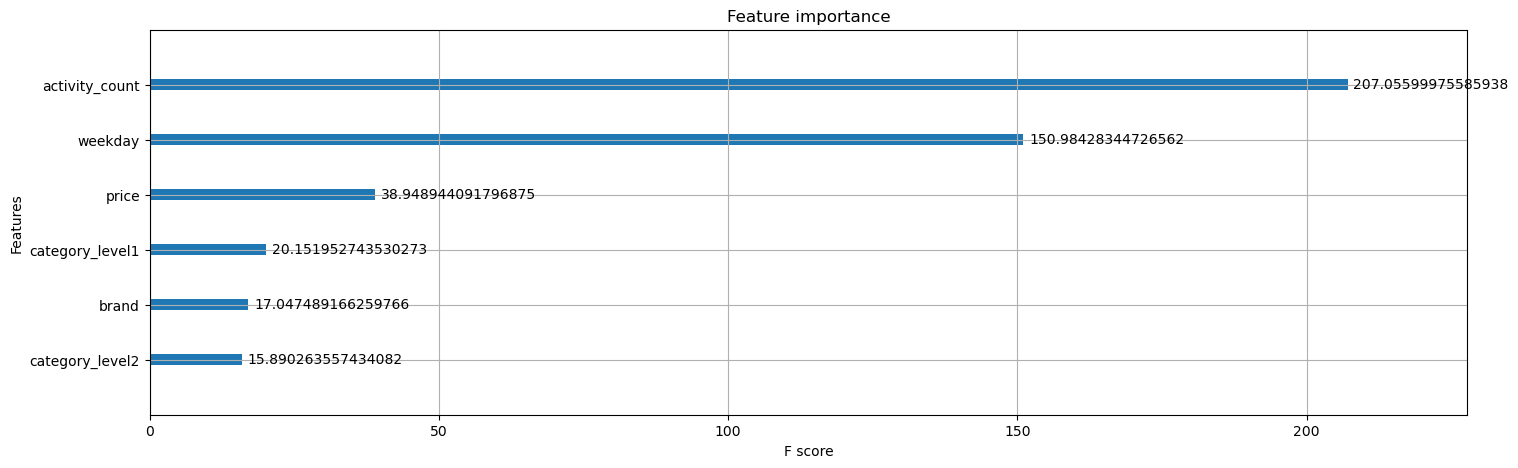

In [95]:
plot_importance(model, max_num_features=10, importance_type="gain")
# plt.rcParams['figure.figsize'] = (40,10)
plt.show()